# CNN 遥感图像分类项目

## 数据说明
This is a 21 class land use image dataset meant for research purposes. 
There are 100 images for each of the following classes:
+ agricultural
+ airplane
+ baseballdiamond
+ beach
+ buildings
+ chaparral
+ denseresidential
+ forest
+ freeway
+ golfcourse
+ harbor
+ intersection
+ mediumresidential
+ mobilehomepark
+ overpass
+ parkinglot
+ river
+ runway
+ sparseresidential
+ storagetanks
+ tenniscourt

Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

Download site: http://weegee.vision.ucmerced.edu/datasets/landuse.html

# 1. 读取原始数据和文件

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.transform import resize
#import cv2

from PIL import Image
import os
from shutil import copyfile

In [2]:
#!pip freeze 

In [3]:
print(keras.__version__)

2.4.0


In [4]:
os.getcwd()
#os.chdir('/Users/qingruan/Desktop/九章算法项目课件/')

'/groups/dats6501/carrieqing'

In [5]:
category_names = [
'agricultural',
    'airplane', 'baseballdiamond', 'beach', 
    'buildings', 'chaparral', 'denseresidential', 'forest', 
    'freeway', 'golfcourse', 'harbor', 'intersection', 
    'mediumresidential', 'mobilehomepark', 
    'overpass', 'parkinglot', 'river', 'runway', 
    'sparseresidential', 'storagetanks', 'tenniscourt'
]

In [6]:
num_images = 100  # per category
nb_classes = len(category_names)
patch_size = 256  # width and height in pixel
channels = 3

In [7]:
# Load the numpy datasets
images_orig = np.load('new data/UCMerced_images_orig_MultiClass21.npy')
labels_num = np.load('new data/UCMerced_labels_num_MultiClass21.npy')

# Convert labels to categorical 'one hot encoded vector' --> required format for softmax cross-entropy loss.
# Create an array of zeros with length nb_classes and put a 1 at the index of the true label.
labels = to_categorical(labels_num, nb_classes)

print('Orginal Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels_num[i])

print('One-hot encoded Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels[i])

print('\nImages shape: {}'.format(images_orig.shape))
print('\nLabel shape: {}'.format(labels.shape))

Orginal Labels: 

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
One-hot encoded Labels: 

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 

# 2. Split train, val and test

In [8]:
nb_images = images_orig.shape[0]
nb_images

2100

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images_orig, labels, 
                                                    test_size=0.2, 
                                                    stratify = labels, 
                                                    random_state=2021)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify = y_train,
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [10]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape,)

(1260, 64, 64, 3) (420, 64, 64, 3) (420, 64, 64, 3) (1260, 21) (420, 21) (420, 21)


Check how many images per class in train/val/test

In [11]:
def unique_counts(arr):
    unique, counts = np.unique(arr, axis=0, return_counts=True)
    unique_num = [np.where(r==1)[0][0] for r in unique] 
    print(dict(zip(unique_num, counts)))

In [12]:
unique_counts(y_train)
unique_counts(y_val)
unique_counts(y_test)

{20: 60, 19: 60, 18: 60, 17: 60, 16: 60, 15: 60, 14: 60, 13: 60, 12: 60, 11: 60, 10: 60, 9: 60, 8: 60, 7: 60, 6: 60, 5: 60, 4: 60, 3: 60, 2: 60, 1: 60, 0: 60}
{20: 20, 19: 20, 18: 20, 17: 20, 16: 20, 15: 20, 14: 20, 13: 20, 12: 20, 11: 20, 10: 20, 9: 20, 8: 20, 7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}
{20: 20, 19: 20, 18: 20, 17: 20, 16: 20, 15: 20, 14: 20, 13: 20, 12: 20, 11: 20, 10: 20, 9: 20, 8: 20, 7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}


# 3. Build CNN Base Model 

**Task**: Implement the following convolutional neural network (CNN). Consider the information in the Figure as well as the additional remarks:

* Use `strides = (1, 1)` for all convolutional layers. 
* Use `padding='same'` to pad the inputs and preserve the spatial dimensions after the convolution.
* Use 'relu' as activation for both conv and dense layers, except the last layer that should output 'softmax' or 'sigmoid' activations (pseudo class probabilities).
* The spatial extent is reduced by using max pooling with `pool_size = (3, 3)`. Set the parameter `strides`, such that the spatial extent is reduced by factor 2 in both spatial dimensions.
* Add a dropout layer with `prob_drop_hidden = 0.5` after the first dense layer.

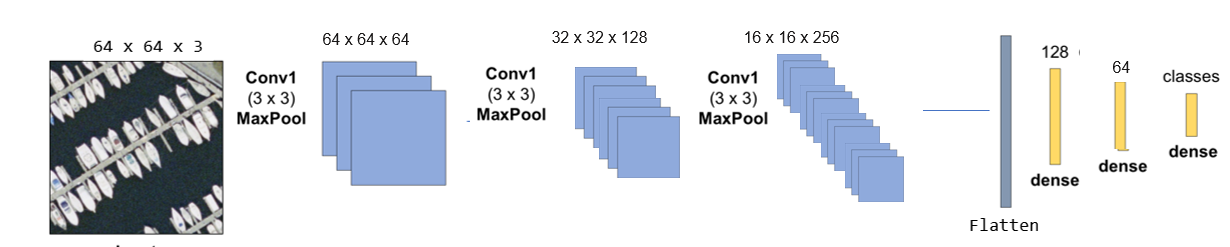

**Questions**:
1. What is the shape of a single filter kernel in the convolutional layer?
2. What is the shape of the output feature maps after the convolutional layer (before the MaxPooling)?
3. `model.summary()` shows the dimension of each layer output. What is the first dimension (None) of the output shape?

In [13]:
# parameters:
input_shape = (int(patch_size/4), int(patch_size/4), channels)
pool_size = (3, 3)                  # size of pooling area for max pooling
prob_drop_hidden = 0.5              # drop probability for dropout @ dense layer

def define_CNN_base():

    model = Sequential()

    # conv1 layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', 
                   input_shape=input_shape))    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', ))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
    
    # conv2 layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # fc2 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model (softmax)
    model.add(Dense(nb_classes, activation='softmax'))
    #model.add(Dense(nb_classes, activation='sigmoid'))

    return model

# clear the session first, such that layer names start with index 1
K.clear_session()
model_CNN_base = define_CNN_base()
model_CNN_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

# 4. Train the base model

In [14]:
# Set hyper parameters
epochs = 1000
base_learning_rate=0.001
batch_size = 32

In [15]:
# Calculate the number of batches per epoch. 
# One epoch is defined as an update pass through the full training data. 
# One iteration is defined as an update through one mini-batch.
batches_per_epoch = y_train.shape[0]//batch_size
# the number of batches to see the full validation data:
validation_steps = y_val.shape[0]//batch_size
print('number of images per batch: {}'.format(batch_size))
print('batches per epoch: {}'.format(batches_per_epoch))
print('validation steps: {}'.format(validation_steps))

number of images per batch: 32
batches per epoch: 39
validation steps: 13


### Data augmentation

In [16]:
# Data Generator provided by keras to load the training data in batches
image_gen = ImageDataGenerator(
    #zoom_range = 0.1,
    width_shift_range=5,   # pixel
    height_shift_range=5,  # pixel
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

# At Test/Validation time without data augmentation
image_gen_test = ImageDataGenerator()

Total Images: 9


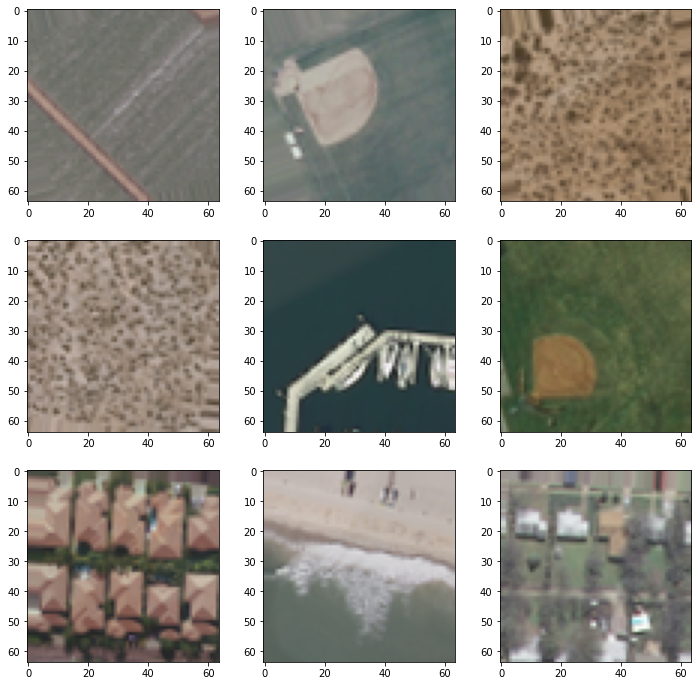

In [17]:
plt.figure(figsize=(12,12))
# configure batch size and retrieve one batch of images
for X_batch, y_batch in image_gen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	print('Total Images:', len(X_batch))
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(64, 64,3))
	# show the plot
	plt.show()
	break
    

In [18]:
train_gen = image_gen.flow(np.array(X_train),
                           y_train,
                           batch_size = batch_size,
                           shuffle = True)
val_gen = image_gen_test.flow(np.array(X_val),
                              y_val,
                              batch_size = batch_size,
                              shuffle = True)


In [19]:
# set your architecture
model = define_CNN_base()

Compile the model with loss and the Adam optimizer.

In [20]:
# Define an optimizer
opt = Adam(lr=base_learning_rate)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])    

In [21]:
checkpoint_best_model = 'model/MultiClass_2Conv_2Conv.hdf5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=600)
mc = ModelCheckpoint(checkpoint_best_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Training commences by making a call to the fit method with our training and validation sets

In [22]:
# Fit the model parameters
print('training...')

history = model.fit(
                x=train_gen,
                steps_per_epoch=batches_per_epoch, 
                epochs=epochs, 
                validation_data=val_gen,
                validation_steps=validation_steps,
                callbacks=[es, mc],
                verbose = 2,
                )

print('done')

training...
Epoch 1/1000
39/39 - 18s - loss: 3.1186 - accuracy: 0.0464 - val_loss: 3.0416 - val_accuracy: 0.0409

Epoch 00001: val_accuracy improved from -inf to 0.04087, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 2/1000
39/39 - 17s - loss: 3.0451 - accuracy: 0.0423 - val_loss: 3.0384 - val_accuracy: 0.0481

Epoch 00002: val_accuracy improved from 0.04087 to 0.04808, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 3/1000
39/39 - 17s - loss: 3.0336 - accuracy: 0.0529 - val_loss: 3.0071 - val_accuracy: 0.1058

Epoch 00003: val_accuracy improved from 0.04808 to 0.10577, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 4/1000
39/39 - 17s - loss: 2.9879 - accuracy: 0.0757 - val_loss: 2.8570 - val_accuracy: 0.1394

Epoch 00004: val_accuracy improved from 0.10577 to 0.13942, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 5/1000
39/39 - 17s - loss: 2.9103 - accuracy: 0.1010 - val_loss: 2.8185 - val_accuracy: 0.1298

Epoch 00005: val_accuracy did not improve


Epoch 00044: val_accuracy did not improve from 0.70192
Epoch 45/1000
39/39 - 16s - loss: 1.0723 - accuracy: 0.6197 - val_loss: 1.0459 - val_accuracy: 0.6803

Epoch 00045: val_accuracy did not improve from 0.70192
Epoch 46/1000
39/39 - 16s - loss: 1.0461 - accuracy: 0.6580 - val_loss: 0.8853 - val_accuracy: 0.7139

Epoch 00046: val_accuracy improved from 0.70192 to 0.71394, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 47/1000
39/39 - 16s - loss: 1.1581 - accuracy: 0.6352 - val_loss: 1.1354 - val_accuracy: 0.6562

Epoch 00047: val_accuracy did not improve from 0.71394
Epoch 48/1000
39/39 - 16s - loss: 1.1135 - accuracy: 0.6327 - val_loss: 0.9537 - val_accuracy: 0.6779

Epoch 00048: val_accuracy did not improve from 0.71394
Epoch 49/1000
39/39 - 16s - loss: 1.1759 - accuracy: 0.6164 - val_loss: 0.9615 - val_accuracy: 0.6971

Epoch 00049: val_accuracy did not improve from 0.71394
Epoch 50/1000
39/39 - 17s - loss: 1.0290 - accuracy: 0.6531 - val_loss: 0.9314 - val_accuracy: 0.71


Epoch 00094: val_accuracy improved from 0.80288 to 0.82212, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 95/1000
39/39 - 23s - loss: 0.4904 - accuracy: 0.8237 - val_loss: 0.6951 - val_accuracy: 0.8173

Epoch 00095: val_accuracy did not improve from 0.82212
Epoch 96/1000
39/39 - 23s - loss: 0.5187 - accuracy: 0.8306 - val_loss: 0.6442 - val_accuracy: 0.8269

Epoch 00096: val_accuracy improved from 0.82212 to 0.82692, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 97/1000
39/39 - 23s - loss: 0.4897 - accuracy: 0.8355 - val_loss: 0.6222 - val_accuracy: 0.8221

Epoch 00097: val_accuracy did not improve from 0.82692
Epoch 98/1000
39/39 - 23s - loss: 0.6381 - accuracy: 0.7932 - val_loss: 0.6708 - val_accuracy: 0.7885

Epoch 00098: val_accuracy did not improve from 0.82692
Epoch 99/1000
39/39 - 22s - loss: 0.5822 - accuracy: 0.8005 - val_loss: 0.8156 - val_accuracy: 0.7837

Epoch 00099: val_accuracy did not improve from 0.82692
Epoch 100/1000
39/39 - 23s - loss: 0.6195 - 


Epoch 00145: val_accuracy did not improve from 0.82933
Epoch 146/1000
39/39 - 22s - loss: 0.3836 - accuracy: 0.8542 - val_loss: 0.8194 - val_accuracy: 0.7981

Epoch 00146: val_accuracy did not improve from 0.82933
Epoch 147/1000
39/39 - 22s - loss: 0.4636 - accuracy: 0.8599 - val_loss: 0.8230 - val_accuracy: 0.7981

Epoch 00147: val_accuracy did not improve from 0.82933
Epoch 148/1000
39/39 - 22s - loss: 0.3930 - accuracy: 0.8770 - val_loss: 0.6659 - val_accuracy: 0.8269

Epoch 00148: val_accuracy did not improve from 0.82933
Epoch 149/1000
39/39 - 23s - loss: 0.3682 - accuracy: 0.8721 - val_loss: 0.7127 - val_accuracy: 0.8197

Epoch 00149: val_accuracy did not improve from 0.82933
Epoch 150/1000
39/39 - 23s - loss: 0.3643 - accuracy: 0.8893 - val_loss: 0.6382 - val_accuracy: 0.8462

Epoch 00150: val_accuracy improved from 0.82933 to 0.84615, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 151/1000
39/39 - 23s - loss: 0.4289 - accuracy: 0.8559 - val_loss: 0.7348 - val_accuracy


Epoch 00196: val_accuracy did not improve from 0.84856
Epoch 197/1000
39/39 - 27s - loss: 0.2684 - accuracy: 0.9088 - val_loss: 1.0402 - val_accuracy: 0.8077

Epoch 00197: val_accuracy did not improve from 0.84856
Epoch 198/1000
39/39 - 27s - loss: 0.3161 - accuracy: 0.8941 - val_loss: 0.7862 - val_accuracy: 0.8173

Epoch 00198: val_accuracy did not improve from 0.84856
Epoch 199/1000
39/39 - 27s - loss: 0.3302 - accuracy: 0.8909 - val_loss: 0.6171 - val_accuracy: 0.8510

Epoch 00199: val_accuracy improved from 0.84856 to 0.85096, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 200/1000
39/39 - 27s - loss: 0.2830 - accuracy: 0.8982 - val_loss: 0.8208 - val_accuracy: 0.8269

Epoch 00200: val_accuracy did not improve from 0.85096
Epoch 201/1000
39/39 - 27s - loss: 0.2907 - accuracy: 0.9112 - val_loss: 0.6674 - val_accuracy: 0.8293

Epoch 00201: val_accuracy did not improve from 0.85096
Epoch 202/1000
39/39 - 27s - loss: 0.3176 - accuracy: 0.9088 - val_loss: 0.9632 - val_accuracy


Epoch 00247: val_accuracy improved from 0.85577 to 0.85817, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 248/1000
39/39 - 27s - loss: 0.2151 - accuracy: 0.9373 - val_loss: 0.8372 - val_accuracy: 0.8365

Epoch 00248: val_accuracy did not improve from 0.85817
Epoch 249/1000
39/39 - 28s - loss: 0.2301 - accuracy: 0.9275 - val_loss: 0.7407 - val_accuracy: 0.8365

Epoch 00249: val_accuracy did not improve from 0.85817
Epoch 250/1000
39/39 - 28s - loss: 0.2162 - accuracy: 0.9251 - val_loss: 0.7167 - val_accuracy: 0.8486

Epoch 00250: val_accuracy did not improve from 0.85817
Epoch 251/1000
39/39 - 27s - loss: 0.2518 - accuracy: 0.9186 - val_loss: 0.8857 - val_accuracy: 0.8341

Epoch 00251: val_accuracy did not improve from 0.85817
Epoch 252/1000
39/39 - 28s - loss: 0.2841 - accuracy: 0.9031 - val_loss: 0.9700 - val_accuracy: 0.8077

Epoch 00252: val_accuracy did not improve from 0.85817
Epoch 253/1000
39/39 - 28s - loss: 0.2233 - accuracy: 0.9316 - val_loss: 0.6991 - val_accuracy


Epoch 00298: val_accuracy did not improve from 0.86058
Epoch 299/1000
39/39 - 28s - loss: 0.1992 - accuracy: 0.9407 - val_loss: 0.9118 - val_accuracy: 0.8317

Epoch 00299: val_accuracy did not improve from 0.86058
Epoch 300/1000
39/39 - 27s - loss: 0.1708 - accuracy: 0.9454 - val_loss: 0.8663 - val_accuracy: 0.8413

Epoch 00300: val_accuracy did not improve from 0.86058
Epoch 301/1000
39/39 - 27s - loss: 0.2008 - accuracy: 0.9316 - val_loss: 0.6727 - val_accuracy: 0.8558

Epoch 00301: val_accuracy did not improve from 0.86058
Epoch 302/1000
39/39 - 28s - loss: 0.1784 - accuracy: 0.9463 - val_loss: 0.8689 - val_accuracy: 0.8365

Epoch 00302: val_accuracy did not improve from 0.86058
Epoch 303/1000
39/39 - 27s - loss: 0.2586 - accuracy: 0.9251 - val_loss: 0.7050 - val_accuracy: 0.8630

Epoch 00303: val_accuracy improved from 0.86058 to 0.86298, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 304/1000
39/39 - 28s - loss: 0.2281 - accuracy: 0.9292 - val_loss: 0.7511 - val_accuracy

Epoch 349/1000
39/39 - 22s - loss: 0.2152 - accuracy: 0.9397 - val_loss: 0.7559 - val_accuracy: 0.8438

Epoch 00349: val_accuracy did not improve from 0.87260
Epoch 350/1000
39/39 - 22s - loss: 0.1991 - accuracy: 0.9422 - val_loss: 0.8761 - val_accuracy: 0.8269

Epoch 00350: val_accuracy did not improve from 0.87260
Epoch 351/1000
39/39 - 22s - loss: 0.2863 - accuracy: 0.9096 - val_loss: 1.2613 - val_accuracy: 0.7909

Epoch 00351: val_accuracy did not improve from 0.87260
Epoch 352/1000
39/39 - 23s - loss: 0.2526 - accuracy: 0.9226 - val_loss: 0.9104 - val_accuracy: 0.8197

Epoch 00352: val_accuracy did not improve from 0.87260
Epoch 353/1000
39/39 - 23s - loss: 0.3133 - accuracy: 0.9096 - val_loss: 1.2257 - val_accuracy: 0.8053

Epoch 00353: val_accuracy did not improve from 0.87260
Epoch 354/1000
39/39 - 23s - loss: 0.3142 - accuracy: 0.9072 - val_loss: 0.7623 - val_accuracy: 0.8389

Epoch 00354: val_accuracy did not improve from 0.87260
Epoch 355/1000
39/39 - 22s - loss: 0.2799 - ac


Epoch 00400: val_accuracy did not improve from 0.87260
Epoch 401/1000
39/39 - 23s - loss: 0.1431 - accuracy: 0.9593 - val_loss: 0.7800 - val_accuracy: 0.8606

Epoch 00401: val_accuracy did not improve from 0.87260
Epoch 402/1000
39/39 - 22s - loss: 0.1831 - accuracy: 0.9471 - val_loss: 0.7601 - val_accuracy: 0.8486

Epoch 00402: val_accuracy did not improve from 0.87260
Epoch 403/1000
39/39 - 22s - loss: 0.2301 - accuracy: 0.9422 - val_loss: 0.8162 - val_accuracy: 0.8462

Epoch 00403: val_accuracy did not improve from 0.87260
Epoch 404/1000
39/39 - 23s - loss: 0.2075 - accuracy: 0.9389 - val_loss: 1.0342 - val_accuracy: 0.8149

Epoch 00404: val_accuracy did not improve from 0.87260
Epoch 405/1000
39/39 - 22s - loss: 0.2069 - accuracy: 0.9407 - val_loss: 0.9519 - val_accuracy: 0.8245

Epoch 00405: val_accuracy did not improve from 0.87260
Epoch 406/1000
39/39 - 22s - loss: 0.1728 - accuracy: 0.9463 - val_loss: 0.5681 - val_accuracy: 0.8822

Epoch 00406: val_accuracy improved from 0.872


Epoch 00451: val_accuracy did not improve from 0.89423
Epoch 452/1000
39/39 - 27s - loss: 0.1798 - accuracy: 0.9430 - val_loss: 0.9426 - val_accuracy: 0.8438

Epoch 00452: val_accuracy did not improve from 0.89423
Epoch 453/1000
39/39 - 28s - loss: 0.2443 - accuracy: 0.9316 - val_loss: 0.8700 - val_accuracy: 0.8317

Epoch 00453: val_accuracy did not improve from 0.89423
Epoch 454/1000
39/39 - 28s - loss: 0.2175 - accuracy: 0.9316 - val_loss: 0.8495 - val_accuracy: 0.8173

Epoch 00454: val_accuracy did not improve from 0.89423
Epoch 455/1000
39/39 - 28s - loss: 0.1795 - accuracy: 0.9479 - val_loss: 0.9420 - val_accuracy: 0.8197

Epoch 00455: val_accuracy did not improve from 0.89423
Epoch 456/1000
39/39 - 28s - loss: 0.1453 - accuracy: 0.9544 - val_loss: 0.8772 - val_accuracy: 0.8389

Epoch 00456: val_accuracy did not improve from 0.89423
Epoch 457/1000
39/39 - 28s - loss: 0.1122 - accuracy: 0.9642 - val_loss: 0.8546 - val_accuracy: 0.8582

Epoch 00457: val_accuracy did not improve fro


Epoch 00503: val_accuracy did not improve from 0.89423
Epoch 504/1000
39/39 - 23s - loss: 0.1765 - accuracy: 0.9406 - val_loss: 0.7892 - val_accuracy: 0.8462

Epoch 00504: val_accuracy did not improve from 0.89423
Epoch 505/1000
39/39 - 23s - loss: 0.1815 - accuracy: 0.9438 - val_loss: 0.7563 - val_accuracy: 0.8438

Epoch 00505: val_accuracy did not improve from 0.89423
Epoch 506/1000
39/39 - 22s - loss: 0.2057 - accuracy: 0.9422 - val_loss: 0.8344 - val_accuracy: 0.8510

Epoch 00506: val_accuracy did not improve from 0.89423
Epoch 507/1000
39/39 - 22s - loss: 0.1983 - accuracy: 0.9381 - val_loss: 0.7004 - val_accuracy: 0.8702

Epoch 00507: val_accuracy did not improve from 0.89423
Epoch 508/1000
39/39 - 22s - loss: 0.1702 - accuracy: 0.9536 - val_loss: 0.8827 - val_accuracy: 0.8462

Epoch 00508: val_accuracy did not improve from 0.89423
Epoch 509/1000
39/39 - 22s - loss: 0.1890 - accuracy: 0.9503 - val_loss: 0.7557 - val_accuracy: 0.8534

Epoch 00509: val_accuracy did not improve fro


Epoch 00555: val_accuracy did not improve from 0.89423
Epoch 556/1000
39/39 - 22s - loss: 0.1227 - accuracy: 0.9552 - val_loss: 0.8594 - val_accuracy: 0.8558

Epoch 00556: val_accuracy did not improve from 0.89423
Epoch 557/1000
39/39 - 23s - loss: 0.1682 - accuracy: 0.9568 - val_loss: 0.7497 - val_accuracy: 0.8510

Epoch 00557: val_accuracy did not improve from 0.89423
Epoch 558/1000
39/39 - 23s - loss: 0.1746 - accuracy: 0.9479 - val_loss: 1.0182 - val_accuracy: 0.8389

Epoch 00558: val_accuracy did not improve from 0.89423
Epoch 559/1000
39/39 - 23s - loss: 0.1187 - accuracy: 0.9625 - val_loss: 0.8385 - val_accuracy: 0.8582

Epoch 00559: val_accuracy did not improve from 0.89423
Epoch 560/1000
39/39 - 22s - loss: 0.1567 - accuracy: 0.9577 - val_loss: 0.8855 - val_accuracy: 0.8654

Epoch 00560: val_accuracy did not improve from 0.89423
Epoch 561/1000
39/39 - 22s - loss: 0.2915 - accuracy: 0.9129 - val_loss: 0.8663 - val_accuracy: 0.8654

Epoch 00561: val_accuracy did not improve fro


Epoch 00607: val_accuracy did not improve from 0.89423
Epoch 608/1000
39/39 - 22s - loss: 0.3207 - accuracy: 0.9235 - val_loss: 0.9413 - val_accuracy: 0.8558

Epoch 00608: val_accuracy did not improve from 0.89423
Epoch 609/1000
39/39 - 23s - loss: 0.2575 - accuracy: 0.9414 - val_loss: 0.8782 - val_accuracy: 0.8558

Epoch 00609: val_accuracy did not improve from 0.89423
Epoch 610/1000
39/39 - 22s - loss: 0.2247 - accuracy: 0.9446 - val_loss: 0.9402 - val_accuracy: 0.8221

Epoch 00610: val_accuracy did not improve from 0.89423
Epoch 611/1000
39/39 - 23s - loss: 0.1373 - accuracy: 0.9552 - val_loss: 0.9458 - val_accuracy: 0.8293

Epoch 00611: val_accuracy did not improve from 0.89423
Epoch 612/1000
39/39 - 22s - loss: 0.2158 - accuracy: 0.9430 - val_loss: 0.9406 - val_accuracy: 0.8317

Epoch 00612: val_accuracy did not improve from 0.89423
Epoch 613/1000
39/39 - 22s - loss: 0.1745 - accuracy: 0.9463 - val_loss: 0.9188 - val_accuracy: 0.8438

Epoch 00613: val_accuracy did not improve fro


Epoch 00659: val_accuracy did not improve from 0.89423
Epoch 660/1000
39/39 - 22s - loss: 0.1396 - accuracy: 0.9528 - val_loss: 0.6734 - val_accuracy: 0.8726

Epoch 00660: val_accuracy did not improve from 0.89423
Epoch 661/1000
39/39 - 22s - loss: 0.1185 - accuracy: 0.9682 - val_loss: 0.8604 - val_accuracy: 0.8606

Epoch 00661: val_accuracy did not improve from 0.89423
Epoch 662/1000
39/39 - 23s - loss: 0.1528 - accuracy: 0.9551 - val_loss: 0.8336 - val_accuracy: 0.8582

Epoch 00662: val_accuracy did not improve from 0.89423
Epoch 663/1000
39/39 - 22s - loss: 0.1596 - accuracy: 0.9528 - val_loss: 0.8020 - val_accuracy: 0.8606

Epoch 00663: val_accuracy did not improve from 0.89423
Epoch 664/1000
39/39 - 23s - loss: 0.1653 - accuracy: 0.9544 - val_loss: 0.8188 - val_accuracy: 0.8486

Epoch 00664: val_accuracy did not improve from 0.89423
Epoch 665/1000
39/39 - 22s - loss: 0.1345 - accuracy: 0.9585 - val_loss: 1.0572 - val_accuracy: 0.8341

Epoch 00665: val_accuracy did not improve fro


Epoch 00711: val_accuracy did not improve from 0.89423
Epoch 712/1000
39/39 - 23s - loss: 0.0995 - accuracy: 0.9674 - val_loss: 1.0363 - val_accuracy: 0.8438

Epoch 00712: val_accuracy did not improve from 0.89423
Epoch 713/1000
39/39 - 23s - loss: 0.1213 - accuracy: 0.9658 - val_loss: 1.0455 - val_accuracy: 0.8462

Epoch 00713: val_accuracy did not improve from 0.89423
Epoch 714/1000
39/39 - 22s - loss: 0.1236 - accuracy: 0.9715 - val_loss: 1.0695 - val_accuracy: 0.8245

Epoch 00714: val_accuracy did not improve from 0.89423
Epoch 715/1000
39/39 - 23s - loss: 0.1433 - accuracy: 0.9617 - val_loss: 0.8490 - val_accuracy: 0.8486

Epoch 00715: val_accuracy did not improve from 0.89423
Epoch 716/1000
39/39 - 22s - loss: 0.0898 - accuracy: 0.9723 - val_loss: 0.8978 - val_accuracy: 0.8317

Epoch 00716: val_accuracy did not improve from 0.89423
Epoch 717/1000
39/39 - 23s - loss: 0.1313 - accuracy: 0.9650 - val_loss: 0.9478 - val_accuracy: 0.8389

Epoch 00717: val_accuracy did not improve fro


Epoch 00763: val_accuracy did not improve from 0.89423
Epoch 764/1000
39/39 - 23s - loss: 0.0911 - accuracy: 0.9691 - val_loss: 0.7915 - val_accuracy: 0.8510

Epoch 00764: val_accuracy did not improve from 0.89423
Epoch 765/1000
39/39 - 22s - loss: 0.1504 - accuracy: 0.9593 - val_loss: 1.0710 - val_accuracy: 0.8365

Epoch 00765: val_accuracy did not improve from 0.89423
Epoch 766/1000
39/39 - 22s - loss: 0.1699 - accuracy: 0.9528 - val_loss: 0.9050 - val_accuracy: 0.8317

Epoch 00766: val_accuracy did not improve from 0.89423
Epoch 767/1000
39/39 - 22s - loss: 0.1656 - accuracy: 0.9577 - val_loss: 0.9259 - val_accuracy: 0.8510

Epoch 00767: val_accuracy did not improve from 0.89423
Epoch 768/1000
39/39 - 23s - loss: 0.3267 - accuracy: 0.9186 - val_loss: 0.9481 - val_accuracy: 0.8317

Epoch 00768: val_accuracy did not improve from 0.89423
Epoch 769/1000
39/39 - 22s - loss: 0.2271 - accuracy: 0.9251 - val_loss: 0.8794 - val_accuracy: 0.8462

Epoch 00769: val_accuracy did not improve fro


Epoch 00815: val_accuracy did not improve from 0.89423
Epoch 816/1000
39/39 - 23s - loss: 0.1258 - accuracy: 0.9658 - val_loss: 0.7654 - val_accuracy: 0.8582

Epoch 00816: val_accuracy did not improve from 0.89423
Epoch 817/1000
39/39 - 22s - loss: 0.1599 - accuracy: 0.9536 - val_loss: 0.8417 - val_accuracy: 0.8558

Epoch 00817: val_accuracy did not improve from 0.89423
Epoch 818/1000
39/39 - 22s - loss: 0.1473 - accuracy: 0.9552 - val_loss: 0.8292 - val_accuracy: 0.8582

Epoch 00818: val_accuracy did not improve from 0.89423
Epoch 819/1000
39/39 - 22s - loss: 0.0865 - accuracy: 0.9715 - val_loss: 1.1236 - val_accuracy: 0.8438

Epoch 00819: val_accuracy did not improve from 0.89423
Epoch 820/1000
39/39 - 23s - loss: 0.1434 - accuracy: 0.9593 - val_loss: 1.0285 - val_accuracy: 0.8125

Epoch 00820: val_accuracy did not improve from 0.89423
Epoch 821/1000
39/39 - 23s - loss: 0.2349 - accuracy: 0.9357 - val_loss: 0.9136 - val_accuracy: 0.8534

Epoch 00821: val_accuracy did not improve fro

In [23]:
def history_plot(model_id, history):
	plt.figure(figsize=(8,10)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.xlabel("Epochs", fontsize = 120)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

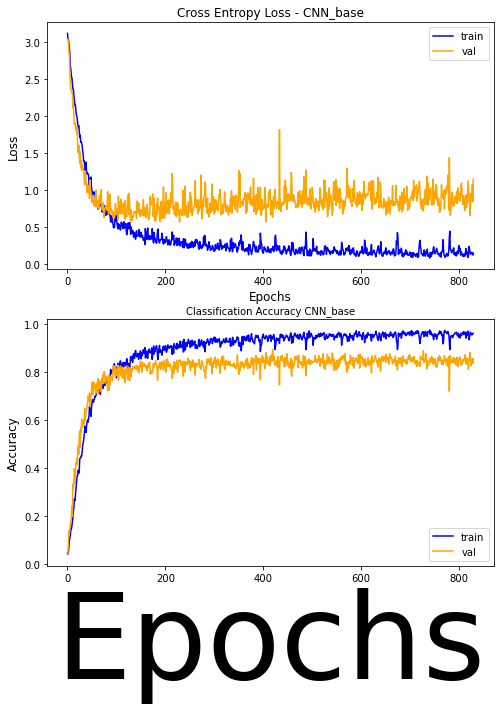

In [24]:
history_plot('CNN_base', history)

#### Saving our model to disk

A Keras model consists of multiple components:

+ An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
+ A set of weights values (the "state of the model").
+ An optimizer (defined by compiling the model).
+ A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).
The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

+ Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
+ Saving the architecture / configuration only, typically as a JSON file.
+ Saving the weights values only. This is generally used when training the model.

In [25]:
saved_model = load_model(checkpoint_best_model)

from datetime import datetime
DTime = datetime.now().strftime('%Y%m%d_%H%M%S')

_, acc = saved_model.evaluate(X_train, y_train, verbose=0)
print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_val, y_val, verbose=0)
print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

save_file = checkpoint_best_model[0:-5] +'_' + DTime + '_ACC' + str(acc_test)+'.h5'
print("Model saved: ", save_file)
saved_model.save(save_file,  save_format="h5")

Model evaluate on train, Accuracy 99.444
Model evaluate on val, Accuracy 89.286
Model evaluate on test, Accuracy 84.524
Model saved:  model/MultiClass_2Conv_2Conv_20210226_024928_ACC84.52.h5


# 5. Prediction on test image

In [26]:
# load the weights form the best epoch
model = saved_model
test_gen = image_gen_test.flow(np.array(X_test),
                              batch_size = batch_size,
                              shuffle = False)
STEP_SIZE_TEST = X_test.shape[0] // batch_size
print('predicting...')
predictions = model.predict(test_gen, 
                            steps = STEP_SIZE_TEST+1)

# convert predictions    
print('num. predictions: ', len(predictions))

predicting...
num. predictions:  420


In [27]:
y_pred = to_categorical(np.argmax(predictions, axis=1), nb_classes)

In [28]:
# classification report
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

                   precision    recall  f1-score   support

     agricultural       0.83      0.95      0.88        20
         airplane       0.69      0.55      0.61        20
  baseballdiamond       1.00      0.85      0.92        20
            beach       0.77      1.00      0.87        20
        buildings       0.95      1.00      0.98        20
        chaparral       0.75      0.75      0.75        20
 denseresidential       0.95      0.95      0.95        20
           forest       1.00      0.95      0.97        20
          freeway       0.78      0.90      0.84        20
       golfcourse       0.95      0.90      0.92        20
           harbor       0.95      1.00      0.98        20
     intersection       0.65      0.55      0.59        20
mediumresidential       0.86      0.95      0.90        20
   mobilehomepark       0.94      0.85      0.89        20
         overpass       1.00      1.00      1.00        20
       parkinglot       1.00      0.75      0.86       

In [29]:
# Confusion matrix
confmat = confusion_matrix( y_test.argmax(axis=1), predictions.argmax(axis=1))
confmat

array([[19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0, 11,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,
         1,  2,  0,  0,  2],
       [ 2,  0, 17,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 15,  0,  0,  2,  0,  0,  2,  0,  1,  0,  0,
         0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0, 18,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,
         0,  0,  0,

In [30]:
def plot_cm(y_true, y_pred, figsize=(12,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d' % (c, s)
            elif c == 0:
                annot[i, j] = ''
            elif i<j:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d' % (c)
    #cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm = pd.DataFrame(cm, index=category_names, columns=category_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"fontsize":12})
    
    

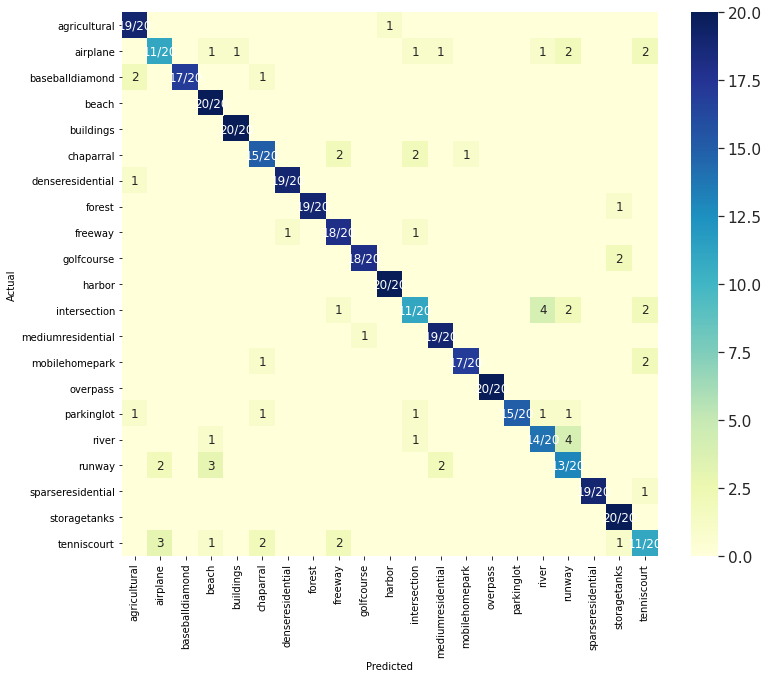

In [31]:
plot_cm( y_test.argmax(axis=1), predictions.argmax(axis=1))

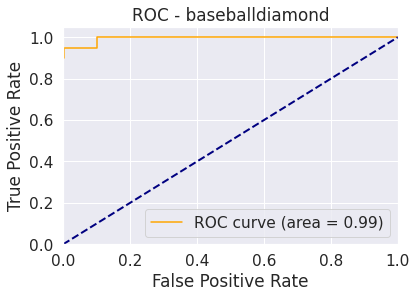

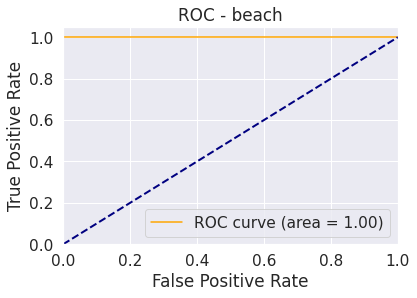

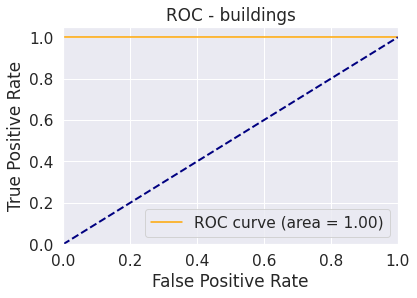

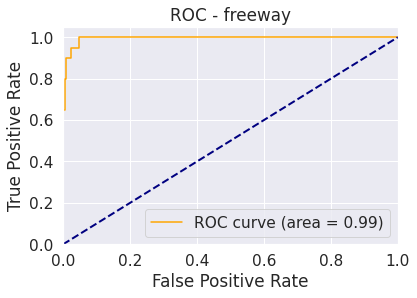

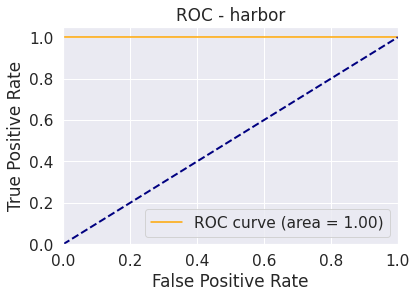

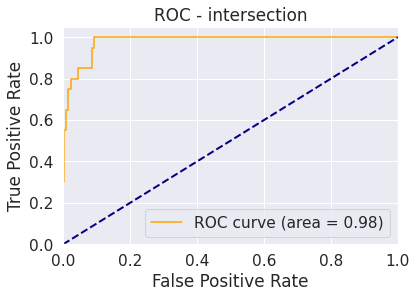

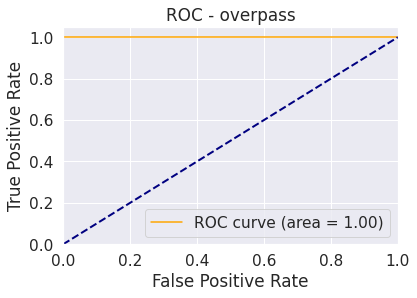

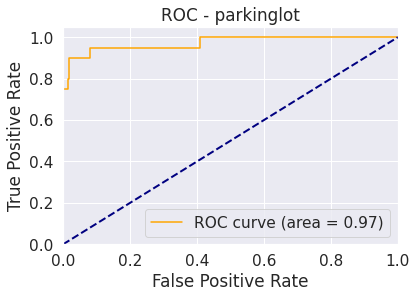

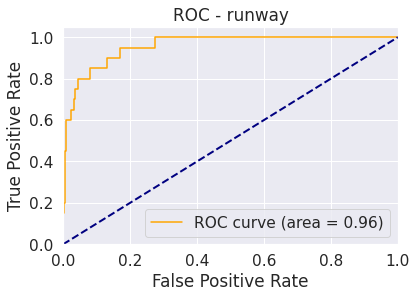

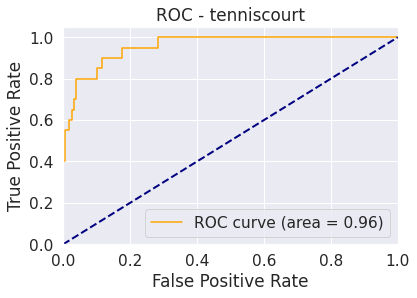

In [32]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(nb_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='orange', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - '+ category_names[i])
    plt.legend(loc="lower right")
    plt.show()

In [33]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

Model evaluate on test, Accuracy 84.524


In [34]:
# VISUALIZE IMAGES

import math

def plotImages_categories( images, labels, predictions, n_cols=4, figsize=(10, 10)):
    fig, axes = plt.subplots(math.ceil(len(images)/n_cols), n_cols, figsize=figsize)
    axes = axes.flatten()
    for i in range(math.ceil(len(images)/n_cols) * n_cols):
        axes[i].set_xticks(())
        axes[i].set_yticks(())
        
        if i < len(images):
            axes[i].imshow(images[i])
            if predictions is not None:
                title = 'LABEL:{}\nPRED: {}'.format(labels[i], predictions[i])

                if predictions[i] != labels[i]:
                    [j.set_linewidth(5) for j in axes[i].spines.values()]
                    [j.set_color('red') for j in axes[i].spines.values()]

            else:
                title = 'LABEL:{}'.format(labels[i])
            axes[i].set_title(title, fontdict={'family':'monospace'}, loc='left',fontsize = 12)
    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(len(category_names)):
    cat = []
    cat_pred = []
    X_test_cat = []
    for j in range(len(y_test)):
        if y_test.argmax(axis=1)[j] == i:
            cat.append(category_names[i])
            cat_pred.append(category_names[predictions.argmax(axis=1)[j]])
            X_test_cat.append(X_test[j])
    
    print('\nCategory:{}, Total Samples:{}'.format(category_names[i], len(cat)))
    
    plotImages_categories(images=X_test_cat, labels=cat,
                          predictions=cat_pred, 
                        figsize=(12, 16))


Category:agricultural, Total Samples:20



Category:airplane, Total Samples:20
